In [1]:
import keras
import numpy as np
import matplotlib.pyplot as plt
from keras.datasets import mnist

np.random.seed(0)

Using TensorFlow backend.


### Load MNIST Dataset

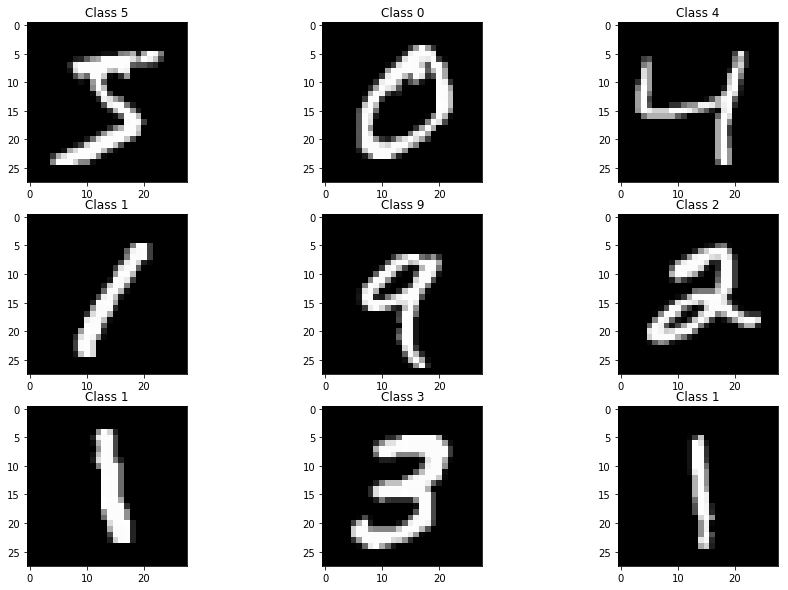

In [2]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

plt.figure(figsize=(15,10))
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.imshow(x_train[i], cmap='gray', interpolation='none')
    plt.title("Class {}".format(y_train[i]))
plt.show()

In [3]:
def show_img(img, label):
    img = img.reshape(28,28)
    
    plt.figure(figsize=(15,5))
    plt.subplot(1, 2, 1)
    plt.imshow(img, cmap='gray')
    
    if type(label) == np.uint8:
        zeros = np.zeros(10)
        zeros[label] = 1
        label = zeros
    
    plt.subplot(1, 2, 2)
    plt.bar(np.arange(10), label, tick_label=np.arange(10))
    plt.xlabel('Number'); plt.ylabel('Probability')
    plt.show()

### Show Image

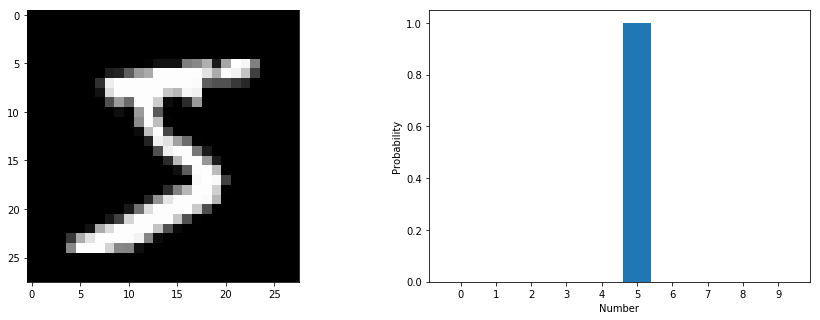

In [4]:
X = x_train[0].reshape(1,-1)/255.; Y = y_train[0]
zeros = np.zeros(10); zeros[Y] = 1
Y = zeros

show_img(X,Y)

# Forward pass for a single example (10 points)
---

Here we implement the forward pass for the network using the single example, $X$, from above

### Initialize weights and Biases

The input dimension is $d = 784$ (the images are originally $28x28 \rightarrow 784$).  
Use $200$ hidden nodes ($h=200$). And there are ten categories of images ($0,1, ...,9$) so $c=10$.

\begin{align}
    \theta^{(1)} &= \begin{bmatrix}
       \theta_{11} & ... & \theta_{1h} \\
       \theta_{21} & ... & \theta_{2h}\\
       \vdots & \vdots & \vdots \\
       \theta_{d1} & ... & \theta_{dh}
     \end{bmatrix} 
    &
    b^{(1)} &= \begin{bmatrix}
       b_{1} \\
       b_{2} \\
       \vdots \\
       b_{h} 
     \end{bmatrix} 
    &
    \theta^{(2)} &= \begin{bmatrix}
       \theta_{11} & ... & \theta_{1c} \\
       \theta_{21} & ... & \theta_{2c}\\
       \vdots & \vdots & \vdots \\
       \theta_{h1} & ... & \theta_{hc}
     \end{bmatrix}
     &
    b^{(2)} &= \begin{bmatrix}
       b_{1} \\
       b_{2} \\
       \vdots \\
       b_{c} 
     \end{bmatrix} 
   \end{align}

**Question:** what is the shape of the first layer weights?  
**Answer:** 784 x 200

**Question:** what is the shape of the second layer weights?  
**Answer:** 200 x 10

In [5]:
num_hidden_nodes = 200; num_classes = 10

# init weights
W1 = np.random.uniform(-1e-3,1e-3,size=(784,num_hidden_nodes))
b1 = np.zeros((1,num_hidden_nodes))

W2 = np.random.uniform(-1e-3,1e-3,size=(num_hidden_nodes,num_classes))
b2 = np.zeros((1,num_classes))

### First layer activations
\begin{equation}
    Z^{(1)} = X^{(1)} \theta^{(1)} + b^{(1)}
\end{equation} 
\begin{equation}
    X^{(2)} = \phi_1 ( Z^{(1)} )
\end{equation}

In [6]:
Z1 = np.matmul(X, W1) + b1

def sigmoid(z):
    return 1 / (1 + np.exp(- z))
    
def d_sigmoid(g):
    return sigmoid(g) * (1. - sigmoid(g))

X2 = sigmoid(Z1)

### Second layer activations
\begin{equation}
    Z^{(2)} = X^{(2)} \theta^{(2)} + b^{(2)}
\end{equation} 

In [7]:
Z2 = np.matmul(X2, W2) + b2

### Softmax Equation
\begin{equation}
    \hat{Y_i} = \frac{e^{z_{i}}}{\sum_{j=1}^{c}e^{z_{j}}}
\end{equation} 

In [8]:
# softmax
def softmax(z):
    # subracting the max adds numerical stability
    shiftx = z - np.max(z)
    exps = np.exp(shiftx)
    return exps / np.sum(exps)

def d_softmax(Y_hat, Y):
    return Y_hat - Y
    
Y_hat = softmax(Z2)

Initially the network guesses all categories equally. As we perform backprop the network will get better at discerning images and their categories.

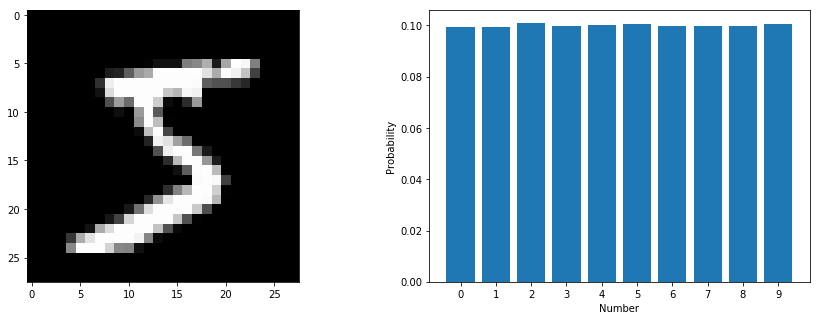

In [9]:
show_img(X,Y_hat[0])

### Calculate Cost

\begin{equation}
    J = - \sum_j y_j \log \hat{y_j}
\end{equation}

In [10]:
cost = -np.sum(Y * np.log(Y_hat))
print('Cost:',cost)

Cost: 2.298818553136685


# Backward pass for single example (15 points)
---
**A note on notation (for the more experienced reader):** Here and in the lecture slides I have used partial derivatives (i.e. $\frac{\partial J}{\partial \theta^{(2)}}$). However, one may notice this is not completely correct as we are dealing with matrices and vectors. These should be jacobians and gradients (i.e. $\nabla_{\theta^{(2)}} J$). I find that it is conceptually easier to grasp the concepts using partials (especially when drawing the computation graph). The jacobian with respect to $\theta^{(2)}$ is simply a matrix of partial derivatives (shown below), hence my abuse of notation: 

\begin{align}
    \nabla_{\theta^{(2)}} J &= \begin{bmatrix}
       \frac{\partial J}{\partial \theta^{(2)}_{11}} & ... & \frac{\partial J}{\partial \theta^{(2)}_{1c}} \\
       \frac{\partial J}{\partial \theta^{(2)}_{21}} & ... & \frac{\partial J}{\partial \theta^{(2)}_{1c}} \\
       \vdots & \vdots & \vdots \\
       \frac{\partial J}{\partial \theta^{(2)}_{h1}} & ... & \frac{\partial J}{\partial \theta^{(2)}_{hc}}
     \end{bmatrix} 
\end{align}

--- 

\begin{equation}
    \frac{\partial J}{\partial Z^{(2)}} = \frac{\partial J}{\partial \hat{Y}} \frac{\partial \hat{Y}}{\partial Z^{(2)}} = \hat{Y} - Y
\end{equation}

In [11]:
dJ_dZ2 = Y_hat - Y

### Second layer weights
\begin{equation}
   \frac{\partial J}{\partial \theta^{(2)}} = \frac{\partial J}{\partial \hat{Y}} \frac{\partial \hat{Y}}{\partial Z^{(2)}} \frac{\partial Z^{(2)}}{\partial \theta^{(2)}} = {X^{(2)}}^T (\hat{Y} - Y) 
\end{equation}  

In [12]:
dJ_dW2 = np.matmul(np.transpose(X2), dJ_dZ2)

### Second layer bias

\begin{equation}
   \frac{\partial J}{\partial b^{(2)}} = \frac{\partial J}{\partial \hat{Y}} \frac{\partial \hat{Y}}{\partial Z^{(2)}} \frac{\partial Z^{(2)}}{\partial b^{(2)}} = (\hat{Y} - Y) 
\end{equation}  

In [13]:
dJ_db2 = Y_hat - Y

### Second layer input

\begin{equation}
   \frac{\partial J}{\partial X^{(2)}} = \frac{\partial J}{\partial \hat{Y}} \frac{\partial \hat{Y}}{\partial Z^{(2)}} \frac{\partial Z^{(2)}}{\partial X^{(2)}} = (\hat{Y} - Y) {\theta^{(2)}}^T
\end{equation} 

In [14]:
dJ_dX2 = np.matmul(dJ_dZ2, np.transpose(W2))

### First layer activation
\begin{equation}
   \frac{\partial J}{\partial Z^{(1)}} = \frac{\partial J}{\partial \hat{Y}} \frac{\partial \hat{Y}}{\partial Z^{(2)}} \frac{\partial Z^{(2)}}{\partial X^{(2)}} \frac{\partial X^{(2)}}{\partial Z^{(1)}} = (\hat{Y} - Y) {\theta^{(2)}}^T * \phi_1'(Z^{(1)})
\end{equation} 

In [15]:
dJ_dZ1 = dJ_dX2 * d_sigmoid(Z1)

### First layer weights
\begin{equation}
    \frac{\partial J}{\partial \theta^{(1)}} = \frac{\partial J}{\partial \hat{Y}} \frac{\partial \hat{Y}}{\partial Z^{(2)}} \frac{\partial Z^{(2)}}{\partial X^{(2)}} \frac{\partial X^{(2)}}{\partial Z^{(1)}} \frac{\partial Z^{(1)}}{\partial \theta^{(1)}}
    =  {X^{(1)}}^T (Y-\hat{Y}) \theta^{(2)} * \phi_1'(Z^{(1)})
\end{equation}

In [16]:
dJ_dW1 = np.matmul(np.transpose(X), dJ_dZ1)

### First layer bias
\begin{equation}
    \frac{\partial J}{\partial b^{(1)}} = \frac{\partial J}{\partial \hat{Y}} \frac{\partial \hat{Y}}{\partial Z^{(2)}} \frac{\partial Z^{(2)}}{\partial X^{(2)}} \frac{\partial X^{(2)}}{\partial Z^{(1)}} \frac{\partial Z^{(1)}}{\partial b^{(1)}}
    = (Y-\hat{Y}) \theta^{(2)} * \phi_1'(Z^{(1)})
\end{equation}

In [17]:
dJ_db1 = np.matmul((Y_hat - Y), np.transpose(W2)) * d_sigmoid(Z1)

### Updates
\begin{align}
    \theta^{(2)} = \theta^{(2)} - \alpha \frac{\partial J}{\partial \theta^{(2)}} \\
    b^{(2)} = b^{(2)} - \alpha \frac{\partial J}{\partial b^{(2)}} \\
    \theta^{(1)} = \theta^{(1)} - \alpha \frac{\partial J}{\partial \theta^{(1)}} \\
    b^{(1)} = b^{(1)} - \alpha \frac{\partial J}{\partial b^{(1)}} \\
\end{align}

In [18]:
lr = 0.1

# weight updates here
W2 -= (lr * dJ_dW2)
b2 -= (lr * dJ_db2)
W1 -= (lr * dJ_dW1)
b1 -= (lr * dJ_db1)

### Sanity Check
* Pass the same input back through the network
* The cost should now be lower
* And the prediction should be more correct
* **Hint:** If the cost did not decrease and the prediction is correct you did something wrong

Cost: 0.053233054212261606


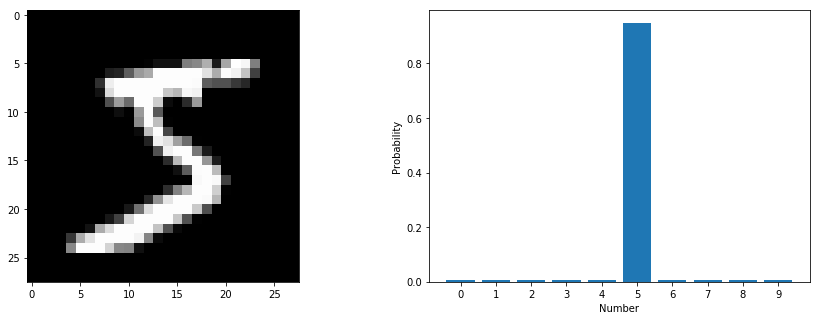

In [19]:
Z1 =  np.matmul(X, W1) + b1
X2 =  sigmoid(Z1)
Z2 =  np.matmul(X2, W2) + b2
Y_hat =  softmax(Z2)

cost = -np.sum(Y * np.log(Y_hat))
print('Cost:',cost)
show_img(X,Y_hat[0])

# Define Neural Network Class (5 points)
---

In [30]:
class NeuralNetwork:
    def __init__(self, num_hidden_nodes, num_classes, lr=0.01):
        # set learning rate
        self.lr = lr
        
        # init weights
        self.W1 = np.random.uniform(-1e-3,1e-3,size=(784,num_hidden_nodes))
        self.b1 = np.zeros((1,num_hidden_nodes))
        
        self.W2 = np.random.uniform(-1e-3,1e-3,size=(num_hidden_nodes,num_classes))
        self.b2 = np.zeros((1,num_classes))
    
    def forward(self, X1):
        '''
        Forward pass through the network
        
        INPUT
            X: input to network
                shape: (?, 784)
        
        RETURN
            Y_hat: prediction from output of network 
                shape: (?, 10)
        '''
        # store input for backward pass
        
        # you can basically copy and past what you did in the forward pass above here
        
        # think about what you need to store for the backward pass
        
        def sigmoid(z):
            return 1 / (1 + np.exp(- z))

        def d_sigmoid(g):
            return sigmoid(g) * (1. - sigmoid(g))
        
        Z1 =  np.matmul(X1, self.W1) + self.b1
        X2 =  sigmoid(Z1)
        Z2 =  np.matmul(X2, self.W2) + self.b2

        Y_hat =  softmax(Z2)
        
        self.X1 = X1
        self.Z1 =  np.matmul(self.X1, self.W1) + self.b1
        self.X2 =  sigmoid(self.Z1)
        self.Z2 =  np.matmul(self.X2, self.W2) + self.b2
        
        Y_hat = softmax(self.Z2)
        
        return Y_hat
    
    def backward(self, Y_hat, Y):
        '''
        Backward pass through network. Update parameters 
        
        INPUT
            Y_hat: Network predicted 
                shape: (?, 10)
            
            Y: Correct target
                shape: (?, 10)
            
        RETURN 
            cost: calculate J for errors 
                type: (float)
            
        '''
        # calculate the cost
        cost = float(-np.sum(Y * np.log(Y_hat)))
        
        # calc gradients
        dJ_dZ2 = Y_hat - Y
        dJ_dW2 = np.matmul(np.transpose(self.X2), dJ_dZ2)
        dJ_db2 = Y_hat - Y
        dJ_dX2 = np.matmul(dJ_dZ2, np.transpose(self.W2))
        dJ_dZ1 = dJ_dX2 * d_sigmoid(self.Z1)
        dJ_dW1 = np.matmul(np.transpose(self.X1), dJ_dZ1)
        dJ_db1 = np.matmul((Y_hat - Y), np.transpose(self.W2)) * d_sigmoid(self.Z1)
        
        # weight updates
        self.W2 = self.W2 - (self.lr * dJ_dW2)
        self.b2 = self.b2 - (self.lr * dJ_db2)
        self.W1 = self.W1 - (self.lr * dJ_dW1)
        self.b1 = self.b1 - (self.lr * dJ_db1)
        
        return cost

# Training (10 points)
---
If you have done things correctly you should not need to change anything in the cell below

In [31]:
nn = NeuralNetwork(200,10,lr=.01)
num_train = float(len(x_train)); num_test = float(len(x_test))
train_cost_store = []
train_acc_store = []
test_acc_store = []
epochs = []

for epoch in range(10):
    train_correct = 0; train_cost = 0
    # training loop
    for i in range(len(x_train)):
        x = x_train[i]; y = y_train[i]
        # standardizing input to range 0 to 1
        X = x.reshape(1,784) /255.
        
        # forward pass through network
        Y_hat = nn.forward(X)

        # get pred number
        pred_num = np.argmax(Y_hat)
        
        # check if prediction was accurate
        if pred_num == y:
            train_correct += 1
            
        # make a one hot categorical vector; same as keras.utils.to_categorical()
        zeros = np.zeros(10); zeros[y] = 1
        Y = zeros
        
        # compute gradients and update weights
        train_cost += nn.backward(Y_hat, Y)
    
    test_correct = 0
    # validation loop
    for i in range(len(x_test)):
        x = x_test[i]; y = y_test[i]
        # standardizing input to range 0 to 1
        X = x.reshape(1,784) /255.
        
        # forward pass
        Y_hat = nn.forward(X)
        
        # get pred number
        pred_num = np.argmax(Y_hat)
        
        # check if prediction was correct
        if pred_num == y:
            test_correct += 1
            
        # no backward pass here!
        
    # compute average metrics for train and test
    train_correct = round(100*(train_correct/num_train), 2)
    test_correct = round(100*(test_correct/num_test ), 2)
    train_cost = round( train_cost/num_train, 2)
    
    train_acc_store.append(train_correct)
    test_acc_store.append(test_correct)
    train_cost_store.append(train_cost)
    epochs.append(epoch)
    
    # print status message every epoch
    log_message = 'Epoch: {epoch}, Train Accuracy: {train_acc}%, Train Cost: {train_cost}, Test Accuracy: {test_acc}%'.format(
        epoch=epoch, 
        train_acc=train_correct, 
        train_cost=train_cost, 
        test_acc=test_correct
    )
    print (log_message)

Epoch: 0, Train Accuracy: 81.47%, Train Cost: 0.57, Test Accuracy: 91.39%
Epoch: 1, Train Accuracy: 93.29%, Train Cost: 0.23, Test Accuracy: 93.86%
Epoch: 2, Train Accuracy: 94.97%, Train Cost: 0.17, Test Accuracy: 95.24%
Epoch: 3, Train Accuracy: 96.06%, Train Cost: 0.14, Test Accuracy: 95.91%
Epoch: 4, Train Accuracy: 96.83%, Train Cost: 0.11, Test Accuracy: 96.36%
Epoch: 5, Train Accuracy: 97.33%, Train Cost: 0.09, Test Accuracy: 96.74%
Epoch: 6, Train Accuracy: 97.69%, Train Cost: 0.08, Test Accuracy: 97.05%
Epoch: 7, Train Accuracy: 97.99%, Train Cost: 0.07, Test Accuracy: 97.14%
Epoch: 8, Train Accuracy: 98.24%, Train Cost: 0.06, Test Accuracy: 97.3%
Epoch: 9, Train Accuracy: 98.46%, Train Cost: 0.06, Test Accuracy: 97.46%


# Performance (5 points)
* These points are reserved for the performance of your network
* You should be able to get at least 90% accuracy on the test set

c:\users\ryank\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:32: RuntimeWarning: overflow encountered in exp


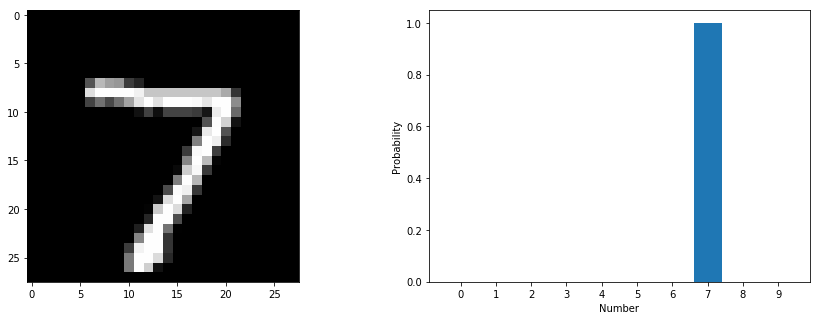

In [32]:
X = x_test[0].reshape(1,784)
Y_hat = nn.forward(X)[0]

show_img(X,Y_hat)

# Plots (5 points)
* Train, test accuracy over time
* Train, test cost over time

Text(0,0.5,'Testing Accuracy')

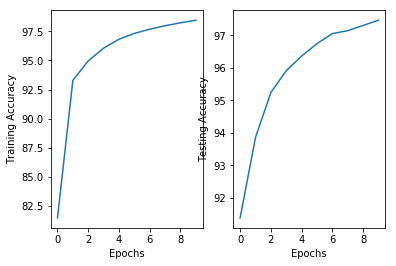

In [37]:
plt.subplot(1,2,1)
plt.plot(epochs,train_acc_store, label="Training Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Training Accuracy")

plt.subplot(1,2,2)
plt.plot(epochs, test_acc_store, label="Testing Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Testing Accuracy")

Text(0,0.5,'Training Cost')

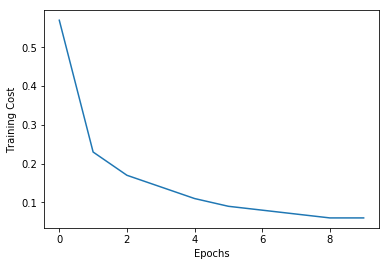

In [38]:
plt.plot(epochs, train_cost_store, label="Training Cost")
plt.xlabel("Epochs")
plt.ylabel("Training Cost")

# Extra Credit (20 points)
---
* Instead of performing classification change this to a regression problem
* Your output would be a single scaler value predicting the number of the input image
* Implement both the forward and backward pass
* Train the network as before

**Approach**  
* What has to change in this problem?
    * Do we need to change activation functions?
    * Number of nodes in a layer?
    * The cost function?

In [ ]:
def relu(z):
    return max(0, z)

def d_relu(z):
    if (z <= 0):
        return 0
    else:
        return 1    

In [ ]:
num_hidden_nodes = 200; num_classes = 10

# init weights
W1 = np.random.uniform(-1e-3,1e-3,size=(784,num_hidden_nodes))
b1 = np.zeros((1,num_hidden_nodes))

W2 = np.random.uniform(-1e-3,1e-3,size=(num_hidden_nodes,num_classes))
b2 = np.zeros((1,num_classes))

class RegressionNeuralNetwork:
    def __init__(self, num_hidden_nodes, num_classes, lr=0.01):
        # set learning rate
        self.lr = lr
        
        # init weights
        self.W1 = np.random.uniform(-1e-3,1e-3,size=(784,num_hidden_nodes))
        self.b1 = np.zeros((1,num_hidden_nodes))
        
        self.W2 = np.random.uniform(-1e-3,1e-3,size=(num_hidden_nodes,num_classes))
        self.b2 = np.zeros((1,num_classes))
    
    def forward(self, X1): 
        Z1 =  np.matmul(X, self.W1) + self.b1
        X2 =  relu(Z1)
        Z2 =  np.matmul(X2, self.W2) + self.b2
        Y_hat =  relu(Z2)
        
        return Y_hat
    
    def backward(self, Y_hat, Y):
        # calculate the cost
        cost = cost = -np.sum(Y * np.log(Y_hat))
        
        # calc gradients
        dJ_dZ2 = Y_hat - Y
        dJ_dW2 = np.matmul(np.transpose(X2), dJ_dZ2)
        dJ_db2 = Y_hat - Y
        dJ_dX2 = np.matmul(dJ_dZ2, np.transpose(self.W2))
        dJ_dZ1 = dJ_dX2 * d_relu(Z1)
        dJ_dW1 = np.matmul(np.transpose(X), dJ_dZ1)
        dJ_db1 = np.matmul((Y_hat - Y), np.transpose(self.W2)) * d_relu(Z1)
        
        # weight updates
        self.W2 = self.W2 - (self.lr * dJ_dW2)
        self.b2 = self.b2 - (self.lr * dJ_db2)
        self.W1 = self.W1 - (self.lr * dJ_dW1)
        self.b1 = self.b1 - (self.lr * dJ_db1)
        
        return cost